[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  4 of 4 completed
Nani?! in data
[[0.14726591 0.00740369 0.28348061 0.90560406]
 [0.16287018 0.00718103 0.23738952 0.93958657]
 [0.15941873 0.00679135 0.2424201  0.91673288]
 ...
 [0.75404546 0.86439547 0.17675049 0.75198726]
 [0.77007934 0.87085282 0.16723317 0.74721776]
 [0.76770556 0.87096412 0.17036029 0.75616054]]


array([[0.11210598],
       [0.11399429],
       [0.10947491],
       ...,
       [0.76521772],
       [0.75404546],
       [0.77007934]])

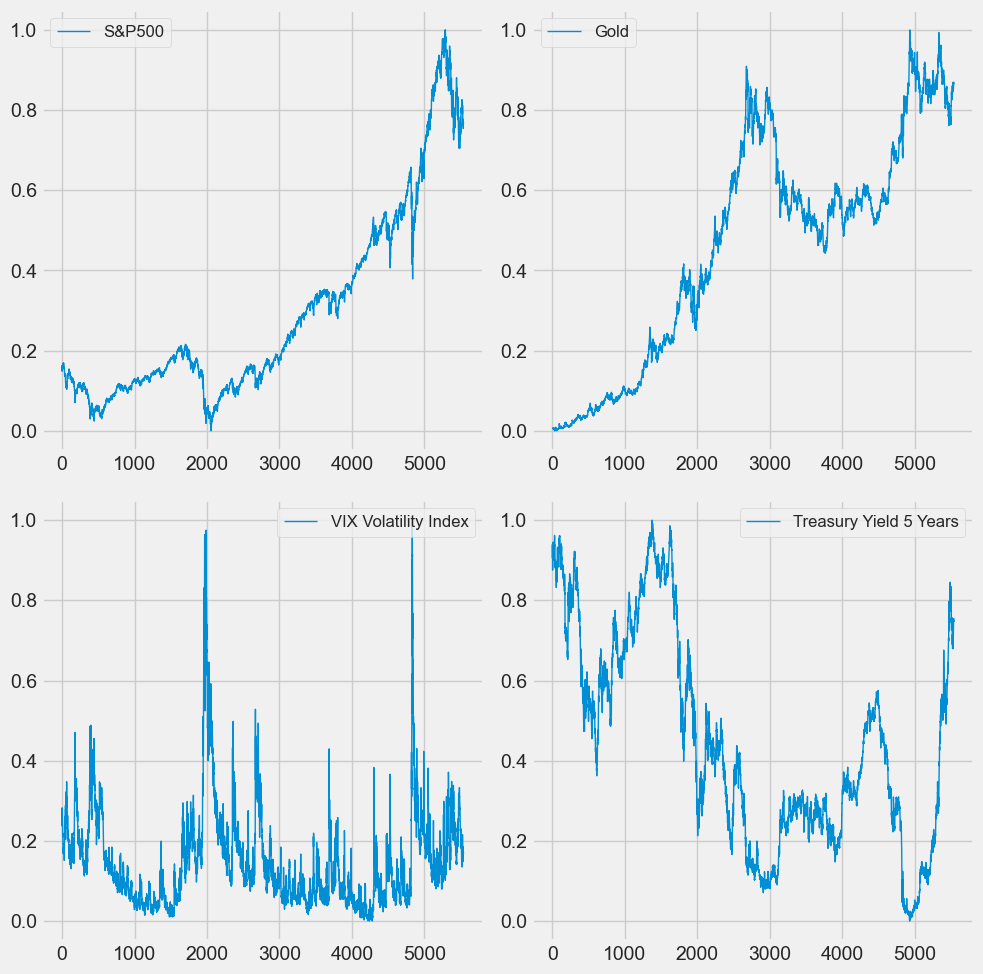

In [747]:
import sys
sys.path.insert(1, r"C:/Users/mihao/OneDrive - Univerza v Ljubljani/Doktorski_studij/Delo/Evolving transformer")
sys.path.insert(1, r"C:\Users\Miha\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\Evolving transformer")
from importlib import reload 
import data.dataclass as dataclass
reload(dataclass)

input_length = 256
output_length = 1
database = dataclass.StockData(input_length,output_length)
database.display_data_norm()

#print(database.data_dropped)
print(database.data_norm)

#print(database.datasnp_dropped)
scalar = database.scalar

database.dataset_input
database.dataset_output


In [748]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class Stockdataset(Dataset):
    def __init__(self, data, input_length = 128, output_length = 1):
        self.data = data
        self.data = torch.from_numpy(data).float()#.view(-1)
        self.seq_len = input_length
        self.out_len = output_length

    def __len__(self):
        return len(self.data)-(self.seq_len+self.out_len+1)

    def __getitem__(self, index):
        return self.data[index : index+self.seq_len], self.data[index+self.seq_len+1: index+self.seq_len+self.out_len+1,0]
        
size_training = int(len(database.data_norm)*0.85)
size_test = len(database.data_norm) - size_training
data_train, data_test = database.data_norm[0:size_training,:], database.data_norm[size_training:len(database.data_norm),:]

print(data_train.shape)
print(data_test.shape)

train_dataset = Stockdataset(data_train, input_length, output_length)
test_dataset = Stockdataset(data_test, input_length, output_length)
whole_dataset = Stockdataset(database.data_norm, input_length, output_length)

print(test_dataset.__getitem__(1)[0].shape)
print(train_dataset.__getitem__(1)[1].shape)
print(whole_dataset.__getitem__(0)[0].shape)


(4708, 4)
(831, 4)
torch.Size([256, 4])
torch.Size([1])
torch.Size([256, 4])


In [749]:
batch_size = 512
train_dataloader = DataLoader(train_dataset, batch_size, drop_last = True, shuffle=True) #drop_last = True ignores last batch is data is not divisable by batch_size
test_dataloader = DataLoader(test_dataset, batch_size, drop_last = True, shuffle=True)
whole_dataloader = DataLoader(whole_dataset, 1, drop_last = False)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


cuda


In [750]:
from importlib import reload 
import compute_ellipse
reload(compute_ellipse)
from numpy.linalg import inv
import time
import pylab as pl
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns

class EvolvingSystem(nn.Module):
    def __init__(self, input_dim, output_dim, cluster_dim, num_clusters,embed_dim,num_heads):
        super(EvolvingSystem, self).__init__()
        self.input_size = input_dim
        self.output_size = output_dim
        self.cluster_dim = cluster_dim
        self.num_clusters = num_clusters
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        #self.etta = torch.nn.Parameter(data=torch.ones(1), requires_grad=True)
        self.mu = torch.nn.Parameter(data = 0.1*torch.randn(self.num_clusters,self.cluster_dim), requires_grad=True)
        self.sigma_inv = torch.nn.Parameter(data=(torch.randn(self.num_clusters,self.cluster_dim, self.cluster_dim)  + 
            	20*torch.diag_embed(torch.ones(self.num_clusters,self.cluster_dim))), requires_grad=True)
        self.msa = nn.MultiheadAttention(self.embed_dim, self.num_heads)
        #self.sigma = torch.nn.Parameter(torch.matmul(self.sigma_inv, torch.transpose(self.sigma_inv, 2, 1)), requires_grad=True)
        #self.sigma_alpha = torch.nn.Parameter(data=torch.randn(self.num_clusters,self.cluster_dim), requires_grad=True)
        self.fc_ant = nn.Linear(input_length, self.cluster_dim) #self.cluster_dim
        self.fc_con = nn.Linear(input_length, output_length) #output_length
        self.sm = torch.nn.Softmax(dim = 1)
        #self.fc_emb = nn.Linear(input_length, 3*self.embed_dim) #output_length
        self.input_layer_norm = nn.LayerNorm(input_length)
        self.ant_norm = nn.LayerNorm(self.cluster_dim)
        self.evol_drop_layer = nn.Dropout(p=0.1)

    def forward(self, x, u):
        #torch.Size([256, 128, 16]); IxBxH
        #self.x = x.flatten()
        x = x.reshape(batch_size,1,input_length)
       
        x_con = x.reshape(batch_size, 1, input_length)
        
        x = self.input_layer_norm(x)
        
        #self.x_emb = self.fc_emb(x)
        #query,key,value = self.x_emb.chunk(3, dim=-1)
        self.x_att, _ = self.msa(x, x, x)
        #self.x_att = self.input_layer_norm(self.x_att)
        self.x_ant = self.fc_ant(self.x_att)
        #self.x_ant = self.ant_norm(self.x_ant)
        
        #self.x_ant = self.input_layer_norm(self.x_ant)
        #self.x_ant = torch.cat((self.x_ant, u.reshape(batch_size,1,1)), dim = 2)

        d = torch.sub(self.mu, self.x_ant)
        dl = d.reshape(batch_size, self.num_clusters, 1, self.cluster_dim)
        
        #TEST OK -> self.mu-self.x_ant[0][0], d[0], dl[0]
        sigma_inv = torch.matmul(self.sigma_inv, torch.transpose(self.sigma_inv, 2, 1))
        #sigma_inv = self.sigma_inv
        
        d2_dS = torch.matmul(dl, sigma_inv)

        dr = d.reshape(batch_size, self.num_clusters, self.cluster_dim, 1)

        d2 = torch.matmul(d2_dS, dr)
        #d2 = torch.pow(d2, torch.pow(self.etta, 2))
        psi = self.sm(-d2).reshape(batch_size, 1, self.num_clusters)
        #psi = self.evol_drop_layer(psi)
        #TEST OK -> self.sm(-d2).reshape(batch_size,1,self.num_clusters)[0], self.sm(-d2)
        
        x_con = x_con.repeat(1,self.num_clusters,1)
        y_con = self.fc_con(x_con)#.reshape(batch_size, -1, self.num_clusters) #.reshape(batch_size, output_length, self.num_clusters)
        
        #print(torch.sum(psi[0]))
        y = torch.matmul(psi, y_con)
        
        #final_out = self.fc(out)
        return y

Parameter containing:
tensor([-0.0099], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.0247, -0.0207, -0.0323,  0.0184, -0.0090, -0.0217,  0.0307, -0.0132,
         -0.0060, -0.0469,  0.0369, -0.0584,  0.0366,  0.0277,  0.0429, -0.0474,
         -0.0046,  0.0596,  0.0121, -0.0292, -0.0295, -0.0158,  0.0124,  0.0052,
          0.0247, -0.0088, -0.0037, -0.0487, -0.0480, -0.0575, -0.0009, -0.0121,
          0.0223,  0.0190, -0.0175,  0.0606, -0.0264,  0.0013, -0.0560,  0.0560,
          0.0586, -0.0247, -0.0199, -0.0156,  0.0379, -0.0362,  0.0450,  0.0053,
          0.0361, -0.0350,  0.0124, -0.0420,  0.0597,  0.0348,  0.0292,  0.0470,
          0.0580, -0.0081,  0.0433,  0.0386, -0.0401,  0.0171,  0.0396, -0.0086,
          0.0135,  0.0166,  0.0219,  0.0325, -0.0503,  0.0502,  0.0094,  0.0095,
         -0.0266,  0.0274, -0.0357, -0.0327,  0.0302, -0.0298, -0.0568, -0.0434,
          0.0235, -0.0257, -0.0608,  0.0385, -0.0468, -0.0618,  0.0012, -0.0089,
         -

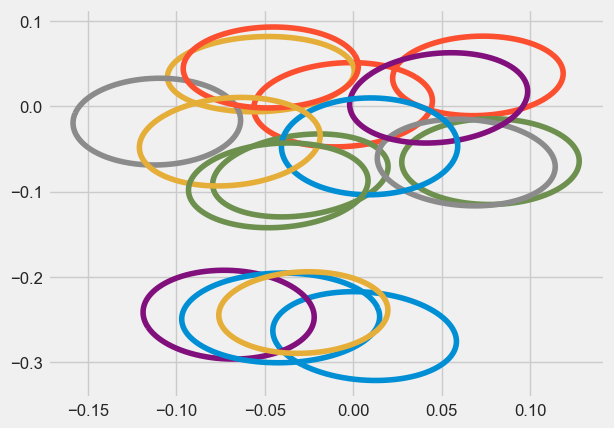

In [751]:
class Lstm_model(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_size, num_layers):
        super(Lstm_model, self).__init__()
        self.num_layers = num_layers
        self.input_size = input_dim
        self.output_size = output_dim
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_size, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, output_dim)
        self.evolve = EvolvingSystem(input_dim, output_dim, cluster_dim, num_clusters,embed_dim,num_heads)
        #self.fc = EvolvingSystem(input_dim, output_dim, cluster_dim, num_clusters,hidden_size)

    def forward(self, x, hn, cn):
        out, (hn, cn) = self.lstm(x, (hn,cn))
        out = self.fc(out)
        final_out = self.evolve(out,x[-1,:,0])
        #final_out = self.fc(out)
        return final_out, hn, cn

    def predict(self, x):
        hn, cn = self.init()
        out = self.fc(out)
        final_out = self.evolve(out, x[-1,:,0])
        #final_out = self.fc(out)
        return final_out, hn, cn 

    def init(self):
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device) #zakaj je batch_size tako?
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        return h0,c0

embed_dim = input_length
num_heads = input_length//32
cluster_dim = 2
num_clusters = 16
input_dim = 4
output_dim = 1
hidden_size = input_length//32
num_layers = 3
model = Lstm_model(input_dim, output_dim, hidden_size, num_layers).to(device)

sigma_inv = model.evolve.sigma_inv
sigma_inv = torch.matmul(sigma_inv, torch.transpose(sigma_inv, 2, 1))
sigma = inv(sigma_inv.detach().cpu().numpy())[:,0:2,0:2]
mu = model.evolve.mu.detach().cpu().numpy()[:,0:2]
ellipse = compute_ellipse.Ellipse(sigma,mu,1)
ellipse_points = ellipse.confidence_ellipse()
ellipse_points = np.einsum('ijk->jik', ellipse_points)
plt.plot(ellipse_points[:,:,0],ellipse_points[:,:,1]) 
display.display(pl.gcf())   
display.clear_output(wait=True)
time.sleep(0.1)

print(model.evolve.fc_con.bias)
print(model.evolve.fc_con.weight)
#print(model.evolve.sigma_inv)
#print(model.evolve.mu)



In [752]:
def train(dataloader):
    hn, cn = model.init()
    model.train()
    loss_sum = 0
    x_ant = np.empty((0,1,cluster_dim))     
    for batch, item in enumerate(dataloader):
        x, y = item
        x = x.to(device)
        y = y.to(device)
        out, hn, cn = model(x.reshape(input_length, batch_size, input_dim), hn, cn)
        #out, hn, cn = model(x, hn, cn)
        loss = loss_fun(out.reshape(batch_size, output_dim,-1), y.reshape(batch_size, output_dim,-1))
        loss_sum = loss_sum + loss.item()
        x_ant = np.append(x_ant, model.evolve.x_ant.detach().cpu().numpy(),axis=0)
        hn = hn.detach() #detach hn is not a parameters and does not need to be updated!!!
        cn = cn.detach()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch == len(dataloader) -1:
            #loss = loss.item()
            print(f"Train loss: {loss_sum:>7f}")
    return loss_sum, x_ant

In [753]:
def test(dataloader):
    hn, cn = model.init()
    loss_sum = 0
    for batch, item in enumerate(dataloader):
        x, y = item
        x = x.to(device)
        y = y.to(device)
        out, hn, cn = model(x.reshape(input_length, batch_size, input_dim), hn, cn)
        loss = loss_fun(out.reshape(batch_size, output_dim,-1), y.reshape(batch_size, output_dim,-1))
        loss_sum = loss_sum + loss.item()
        if batch == len(dataloader) -1:
            #loss = loss.item()
            print(f"Test loss: {loss_sum:>7f}")   
    return loss_sum
            

In [754]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

lstm.weight_ih_l0 tensor([[-0.1428, -0.0155, -0.2063,  0.2206],
        [ 0.1239, -0.0147, -0.0285,  0.2955],
        [ 0.3033, -0.1878, -0.1547,  0.0171],
        [ 0.1539, -0.2735,  0.0254,  0.0641],
        [-0.2472,  0.2306,  0.1359, -0.0900],
        [ 0.2900, -0.0294, -0.2511, -0.2689],
        [-0.0081,  0.1440, -0.1069,  0.2414],
        [ 0.2282, -0.1341,  0.1229,  0.0448],
        [ 0.0976,  0.2085,  0.1160, -0.1680],
        [ 0.3071,  0.0090,  0.1168,  0.1185],
        [ 0.2623,  0.0829,  0.3394, -0.2792],
        [-0.2301,  0.2236,  0.2278, -0.3317],
        [ 0.0260, -0.1195,  0.1523, -0.2941],
        [-0.1527,  0.2588,  0.0992,  0.3301],
        [ 0.2514, -0.0372, -0.0503,  0.1043],
        [ 0.2076, -0.3421,  0.2392,  0.0611],
        [ 0.0670,  0.3484, -0.1942,  0.0853],
        [ 0.0993,  0.2257, -0.2183, -0.0111],
        [-0.2406, -0.2094, -0.2494, -0.1017],
        [ 0.0586, -0.2411,  0.1376,  0.0550],
        [ 0.2873,  0.0856, -0.1708, -0.0841],
        [ 0.2436

In [755]:

from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture

batch_size = 512
best_model = 1
loss_fun = nn.MSELoss()
gmm = GaussianMixture(n_components=num_clusters, covariance_type='full', init_params="kmeans")

lr = 1e-3
for p in model.parameters():
    p.requires_grad = True
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

train_iterations = 100
for i in range(train_iterations):

    epochs = 20
    for epoch in range(epochs):
        print(f"Epoch {epoch}")
        loss_train, x_ant_train = train(train_dataloader)
        loss_test = test(test_dataloader)
        state_dict = model.state_dict()
        if (best_model > loss_train):
            best_model = loss_train
            torch.save(state_dict, "model_evolve.pt")
            
        #state_dict['model.evolve.mu'] = torch.from_numpy(gmm.means_)
        #state_dict['model.evolve.sigma_inv'] = torch.from_numpy(inv(gmm.covariances_))
        #model.load_state_dict(state_dict)
        #sns.heatmap(model.x_ant.detach().cpu().numpy()[0,:,:], vmin=0, vmax=1.0, cmap="OrRd")
        #plt.plot(model.evolve.x_ant.detach().cpu().numpy()[0,0,:])
    
        
    gmm = GaussianMixture(n_components=num_clusters, covariance_type='full', init_params="kmeans")
    #gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(sigma)).transpose((0, 2, 1))
    gmm.fit(x_ant_train[:,0,:])
    mu = gmm.means_
    sigma_inv = (gmm.covariances_)
    u, s, v   = np.linalg.svd(sigma_inv, full_matrices=True)
    s_sqrt = torch.diag_embed(torch.from_numpy(np.sqrt(s))).numpy()
    sigma_inv = inv(np.matmul(s_sqrt, v))
    with torch.no_grad():
        for name, param in model.named_parameters():
            if 'evolve.mu' == name:
                param.copy_(torch.from_numpy(mu))
            if 'evolve.sigma_inv' == name:
                param.copy_(torch.from_numpy(sigma_inv))
    if True:
        """
        nc_plot = num_clusters
        sigma = gmm.covariances_[0:nc_plot,0:2,0:2]
        mu = gmm.means_[0:nc_plot,0:2]
        ellipse = compute_ellipse.Ellipse(sigma,mu,1)
        ellipse_points = ellipse.confidence_ellipse()
        ellipse_points = np.einsum('ijk->jik', ellipse_points)
        plt.plot(x_ant_train[:,0,0],x_ant_train[:,0,1],'.k')
        plt.plot(ellipse_points[:,:,0],ellipse_points[:,:,1],'r')
        plt.show() 
        """
        sigma_inv = model.evolve.sigma_inv
        sigma_inv = torch.matmul(sigma_inv, torch.transpose(sigma_inv, 2, 1))
        sigma = inv(sigma_inv.detach().cpu().numpy())
        nc_plot = num_clusters
        sigma = sigma[0:nc_plot,0:2,0:2]
        mu = model.evolve.mu.detach().cpu().numpy()
        mu = mu[0:nc_plot,0:2]
        ellipse = compute_ellipse.Ellipse(sigma,mu,1)
        ellipse_points = ellipse.confidence_ellipse()
        ellipse_points = np.einsum('ijk->jik', ellipse_points)
        plt.plot(x_ant_train[:,0,0],x_ant_train[:,0,1],'.k')
        plt.plot(ellipse_points[:,:,0],ellipse_points[:,:,1])
        plt.show()  

            


Epoch 0
Train loss: 0.347215
Test loss: 0.286735
Epoch 1
Train loss: 0.222338
Test loss: 0.346225
Epoch 2
Train loss: 0.169337
Test loss: 0.444196
Epoch 3
Train loss: 0.171449
Test loss: 0.376729
Epoch 4
Train loss: 0.165777
Test loss: 0.349309
Epoch 5
Train loss: 0.160863
Test loss: 0.398213
Epoch 6
Train loss: 0.159414
Test loss: 0.377266
Epoch 7
Train loss: 0.159959
Test loss: 0.374686
Epoch 8
Train loss: 0.159079
Test loss: 0.380530
Epoch 9
Train loss: 0.159227
Test loss: 0.375282
Epoch 10
Train loss: 0.160437
Test loss: 0.374062
Epoch 11
Train loss: 0.160899
Test loss: 0.379033
Epoch 12
Train loss: 0.160258
Test loss: 0.365644
Epoch 13
Train loss: 0.160536
Test loss: 0.375145
Epoch 14
Train loss: 0.162541
Test loss: 0.365732
Epoch 15
Train loss: 0.159959
Test loss: 0.371196
Epoch 16
Train loss: 0.158569
Test loss: 0.371280
Epoch 17
Train loss: 0.159910
Test loss: 0.360568
Epoch 18
Train loss: 0.161019
Test loss: 0.366418
Epoch 19
Train loss: 0.159689
Test loss: 0.366684
Epoch 20
T

KeyboardInterrupt: 

In [ ]:
import math
from sklearn.metrics import mean_squared_error
import numpy as np
def calculate_metrics(dataloader):
    pred_arr = []
    y_arr = []
    with torch.no_grad():
        hn, cn = model.init()
        for batch, item in enumerate(dataloader):
            x, y = item
            x, y = x.to(device), y.to(device)
            x = x.view(input_length, batch_size, input_dim)
            pred = model(x, hn, cn)
            pred = pred.view(batch_size, -1,1)
            pred = np.repeat(pred.detach().cpu().numpy(),input_dim,axis=2)
            pred = scalar.inverse_transform(pred)[:,0].reshape(-1)
            y = np.repeat(y.detach().cpu().numpy().reshape(-1,1),input_dim,axis=1)
            y = scalar.inverse_transform(y)[:,0].reshape(-1)
            pred_arr = pred_arr + list(pred)
            y_arr = y_arr + list(y)

        return math.sqrt(mean_squared_error(y_arr,pred_arr))



In [ ]:
from torchsummary import summary

print(model.evolve.fc_con.bias)
print(model.evolve.fc_con.weight)
#print(model.evolve.sigma_inv)
#print(model.evolve.mu)

#summary(model,[(input_length, 1, input_dim),(num_layers, 1, hidden_size),(num_layers, 1, hidden_size)])

model.load_state_dict(torch.load("model_evolve.pt"))
model.eval()


Parameter containing:
tensor([0.0116], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-2.3566e-02, -2.7931e-02, -2.2429e-02, -1.5479e-02,  6.6458e-02,
          6.0321e-02,  6.4823e-02,  5.3599e-02,  4.9606e-02,  5.8981e-03,
          5.5205e-02,  3.6712e-02,  4.7915e-02,  5.6776e-02, -2.9719e-02,
          1.3284e-02,  4.3251e-02,  2.1732e-02,  5.8662e-02,  4.7342e-02,
          5.8652e-02, -1.2717e-02,  6.3792e-02, -3.7599e-02,  1.2946e-02,
          7.5647e-02, -2.7826e-02, -3.5800e-02,  2.4654e-02,  8.2753e-04,
          2.6414e-02, -8.0352e-04,  7.9128e-02,  8.0695e-02, -3.1540e-02,
          2.9907e-02, -4.1312e-02,  2.7275e-02,  1.7983e-03,  3.3918e-02,
          5.5913e-03,  7.4935e-02,  7.8864e-02,  2.7426e-02,  3.4404e-02,
          6.9569e-02, -3.1425e-02,  1.5067e-02,  5.9949e-02, -8.0838e-03,
          6.9288e-02,  1.9787e-02,  6.6228e-02, -3.7535e-02,  4.9250e-02,
         -2.7948e-02, -1.3854e-02, -3.0039e-02,  5.0236e-02,  9.6837e-03,
         -3.07

Lstm_model(
  (lstm): LSTM(4, 8, num_layers=3)
  (fc): Linear(in_features=8, out_features=1, bias=True)
  (evolve): EvolvingSystem(
    (msa): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (fc_ant): Linear(in_features=256, out_features=2, bias=True)
    (fc_con): Linear(in_features=256, out_features=1, bias=True)
    (sm): Softmax(dim=1)
    (input_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (ant_norm): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
    (evol_drop_layer): Dropout(p=0.1, inplace=False)
  )
)

In [ ]:

#print(f"Train MSE loss {calculate_metrics(train_dataloader)}")
#print(f"Test MSE loss {calculate_metrics(test_dataloader)}")

In [ ]:
def simulate(dataloader):
    pred_arr = []
    y_arr = []
    x_ant = np.empty((0,1,cluster_dim))
    with torch.no_grad():
        hn, cn = model.init()
        for batch, item in enumerate(dataloader):
            x, y = item
            x, y = x.to(device), y.to(device)
            #pred,hn,cn = model(x.reshape(input_length, batch_size, input_dim), hn, cn)#[0]
            #pred = model.predict(x.reshape(input_length, batch_size, input_dim))[0]
            pred,hn,cn = model(x.reshape(input_length, batch_size, input_dim), hn, cn)
            pred = pred.detach().cpu().numpy().reshape(-1,1)
            #pred = pred.view(1, output_length)
            #pred = np.repeat(pred.detach().cpu().numpy(),input_dim,axis=1)
            #pred = scalar.inverse_transform(pred)[:,0].reshape(-1)
            #y = np.repeat(y.detach().cpu().numpy().reshape(-1,1),input_dim,axis=1)
            #y = scalar.inverse_transform(y)[:,0].reshape(-1)
            y = y.detach().cpu().numpy().reshape(-1,1)
            pred_arr = pred_arr + list(pred)
            y_arr = y_arr + list(y)
            x_ant = np.append(x_ant, model.evolve.x_ant.detach().cpu().numpy(),axis=0)
    return pred_arr, y_arr, x_ant

    
batch_size = 1
whole_pred_arr, whole_y_arr, x_ant  = simulate(whole_dataloader)



KeyboardInterrupt: 

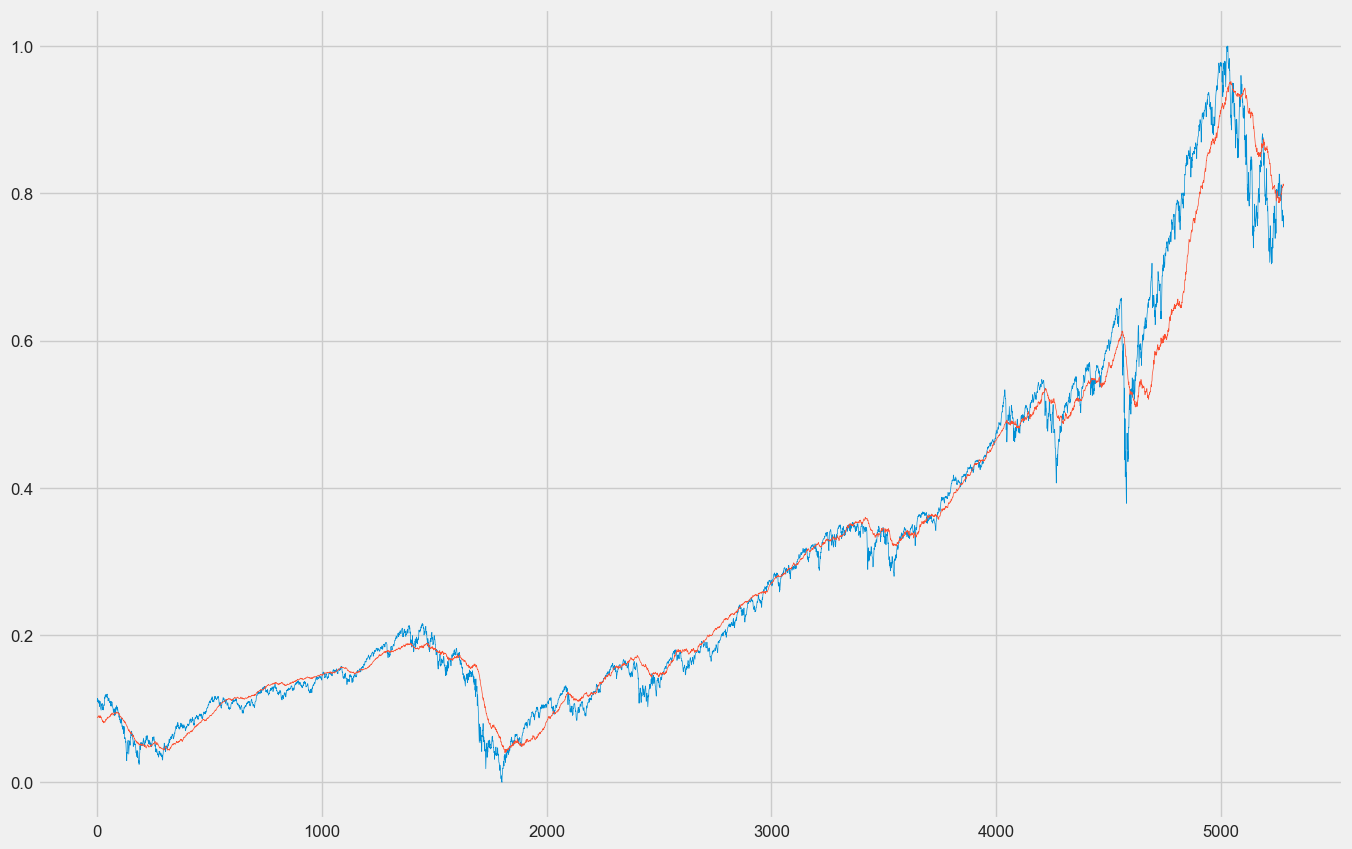

In [ ]:
import matplotlib.pyplot as plt
fig1, axes1 = plt.subplots(figsize = (15, 10))
axes1.plot(whole_y_arr, linewidth=0.5)
axes1.plot(whole_pred_arr, linewidth=0.5)
fig1.savefig("model_evolve.pdf")

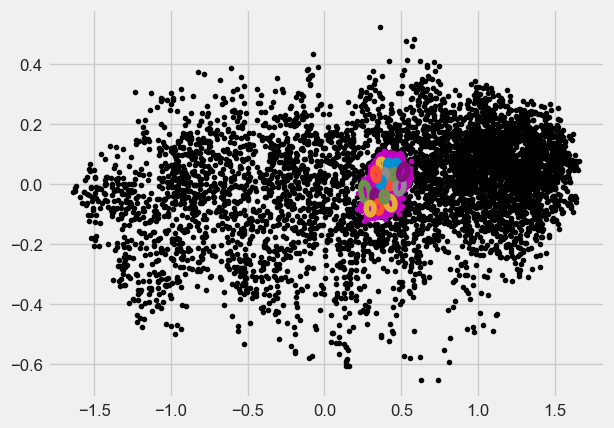

In [ ]:
from importlib import reload 
import compute_ellipse
reload(compute_ellipse)
from numpy.linalg import inv

sigma_inv = model.evolve.sigma_inv
sigma_inv = torch.matmul(sigma_inv, torch.transpose(sigma_inv, 2, 1))
sigma = inv(sigma_inv.detach().cpu().numpy())

nc_plot = num_clusters
sigma = sigma[0:nc_plot,0:2,0:2]
mu = model.evolve.mu.detach().cpu().numpy()
mu = mu[0:nc_plot,0:2]

ellipse = compute_ellipse.Ellipse(sigma,mu,1)
ellipse_points = ellipse.confidence_ellipse()
ellipse_points = np.einsum('ijk->jik', ellipse_points)
plt.plot(x_ant[:,0,0],x_ant[:,0,1],'.k')
plt.plot(x_ant_train[:,0,0],x_ant_train[:,0,1],'.m')
plt.plot(ellipse_points[:,:,0],ellipse_points[:,:,1])
plt.show()  


In [ ]:
history -g


 1/1: !python tools/test.py configs/swin/mask_rcnn_swin_tiny_patch4_window7_mstrain_480-800_adamw_1x_coco_wood.py work_dirs/mask_rcnn_swin_tiny_patch4_window7_mstrain_480-800_adamw_1x_coco_wood/latest.pth --show-dir results_wood/inference --out results_wood/results.pkl --eval bbox --options "jsonfile_prefix=results_wood"
 1/2: !python tools/test.py configs/swin/mask_rcnn_swin_tiny_patch4_window7_mstrain_480-800_adamw_1x_coco_wood.py work_dirs/mask_rcnn_swin_tiny_patch4_window7_mstrain_480-800_adamw_1x_coco_wood/latest.pth --show-dir results_wood/inference --out results_wood/results.pkl --eval bbox --options "jsonfile_prefix=results_wood"
 2/1: !python tools/test.py configs/swin/mask_rcnn_swin_tiny_patch4_window7_mstrain_480-800_adamw_1x_coco_wood.py work_dirs/mask_rcnn_swin_tiny_patch4_window7_mstrain_480-800_adamw_1x_coco_wood/latest.pth --show-dir results_wood/inference --out results_wood/results.pkl --eval bbox --options "jsonfile_prefix=results_wood"
 3/1: !python tools/test.py con

In [ ]:
'''
%matplotlib inline
import time
import pylab as pl
from IPython import display
#fig2, axes2 = plt.subplots(figsize = (5, 3), linewidth=0.5)
#line1, = axes2.plot(np.zeros(output_length))
#line2, = axes2.plot(np.zeros(output_length))

import matplotlib.pyplot as plt
import time

def simulate(dataloader):
    pred_arr = []
    y_arr = []
    with torch.no_grad():
        hn, cn = model.init()
        for batch, item in enumerate(dataloader):
            x, y = item
            x, y = x.to(device), y.to(device)
            pred,hn,cn = model(x.reshape(input_length, batch_size, input_dim), hn, cn) #[0]
            pred = pred.detach().cpu().numpy().reshape(-1,1)
            #pred = pred.view(1, output_length)
            #pred = np.repeat(pred.detach().cpu().numpy(),input_dim,axis=1)
            #pred = scalar.inverse_transform(pred)[:,0].reshape(-1)
            #y = np.repeat(y.detach().cpu().numpy().reshape(-1,1),input_dim,axis=1)
            #y = scalar.inverse_transform(y)[:,0].reshape(-1)
            y = y.detach().cpu().numpy().reshape(-1,1)
            pred_arr = np.append( pred_arr, pred)
            y_arr = np.append(y_arr, y)

            
            #axes2.cla()  
            #line1.set_ydata(pred_arr)
            #line2.set_ydata(y_arr)
            plt.plot(pred_arr,'b')
            plt.plot(y_arr,'r')
            #fig2.tight_layout()
            #fig2.show()

            display.display(pl.gcf())   
            display.clear_output(wait=True)
            time.sleep(0.1)
            
    return pred_arr, y_arr

batch_size = 1
whole_pred_arr, whole_y_arr = simulate(whole_dataloader)
'''

"\n%matplotlib inline\nimport time\nimport pylab as pl\nfrom IPython import display\n#fig2, axes2 = plt.subplots(figsize = (5, 3), linewidth=0.5)\n#line1, = axes2.plot(np.zeros(output_length))\n#line2, = axes2.plot(np.zeros(output_length))\n\nimport matplotlib.pyplot as plt\nimport time\n\ndef simulate(dataloader):\n    pred_arr = []\n    y_arr = []\n    with torch.no_grad():\n        hn, cn = model.init()\n        for batch, item in enumerate(dataloader):\n            x, y = item\n            x, y = x.to(device), y.to(device)\n            pred,hn,cn = model(x.reshape(input_length, batch_size, input_dim), hn, cn) #[0]\n            pred = pred.detach().cpu().numpy().reshape(-1,1)\n            #pred = pred.view(1, output_length)\n            #pred = np.repeat(pred.detach().cpu().numpy(),input_dim,axis=1)\n            #pred = scalar.inverse_transform(pred)[:,0].reshape(-1)\n            #y = np.repeat(y.detach().cpu().numpy().reshape(-1,1),input_dim,axis=1)\n            #y = scalar.inverse